In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.build import bulk
from abtem.plot import show_atoms
import numpy as np
import cupy as cp
from abtem.temperature import TDS

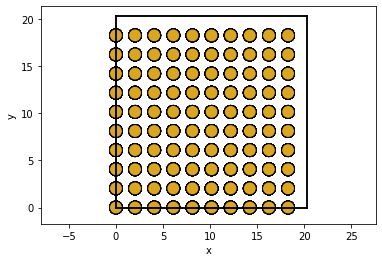

In [41]:
atoms = bulk('Au', 'fcc', a=4.06, cubic=True)
atoms *= (5,5,30)
show_atoms(atoms)

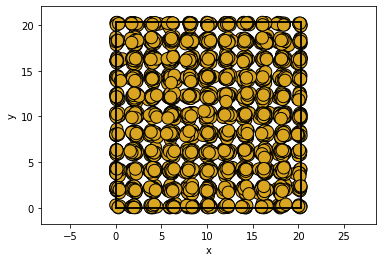

In [46]:
tds = TDS(atoms, 10, {'Au':.2}, seed=7)

atoms_conf = next(tds.generate_atoms())
show_atoms(atoms_conf)

In [47]:
from abtem.potentials import Potential

In [155]:
potential = Potential(tds, sampling=.02)
potential.grid.snap_to_power(2)
#g = potential.generate_tds_potentials()

In [156]:
potential.gpts

array([1024, 1024])

In [52]:
potential_conf = next(g)

NameError: name 'g' is not defined

The ETA after the first TDS configuration is overestimated by an order of magnitude, since the cache of potential integrals is getting filled.

In [53]:
from abtem.waves import PlaneWave

wave = PlaneWave(energy=300e3, device='cpu')

exit_wave = wave.multislice(potential)

In [13]:
#exit_wave.array

In [56]:
patterns = exit_wave.diffraction_pattern()

#patterns.array

(<matplotlib.axes._subplots.AxesSubplot at 0x21731875a88>,
 <matplotlib.image.AxesImage at 0x21731853948>)

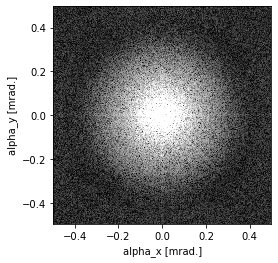

In [57]:
patterns[0].show(display_func=lambda x: np.log(1 + 1e-2 * x), vmax=10)

(<matplotlib.axes._subplots.AxesSubplot at 0x2173f198588>,
 <matplotlib.image.AxesImage at 0x21739e967c8>)

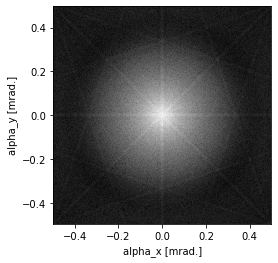

In [58]:
patterns.mean(0).show(display_func=lambda x: np.log(1 + 1e-2 * x), vmax=15, cmap='gray')

## STEM with TDS

Calculating (4D)-STEM with TDS is no different than without, the only exception is that the potential can no longer be calculated explicitly beforehand. Instead you have to pay attention to the `precalculate` and `storage` arguments of the potential. If `precalculate` is true the potential will be calculated before scanning, this is much faster, and should only be set to false if you run out of memory. The `storage` argument only matters for GPU calculations, it can be set to `device` or `host`, setting it to device is faster, but means that the potential is stored on the GPU, which may have limited memory. When `storage` is set to host, the indicidual slices are transferred to the device, greatly reducing memory consumption.

(<matplotlib.axes._subplots.AxesSubplot at 0x21777086c48>,
 <matplotlib.image.AxesImage at 0x21754fd4d48>)

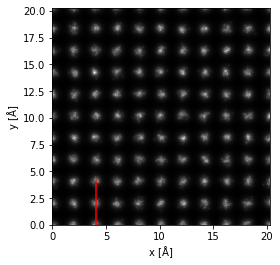

In [157]:
from ase.io import read
from abtem.scan import LineScan
from abtem.detect import AnnularDetector
from abtem.waves import Probe
from abtem.measure import Measurement

atoms = read('graphene.cif') * (5, 3, 1)
atoms.center(vacuum=3,axis=2)

#potential = Potential(TDS(atoms, 50, {'C':.1}, seed=7), sampling=.03)

linescan = LineScan(start=[4.06, 0], end=[4.06, 4.06], gpts=20)

probe = Probe(energy=300e3, semiangle_cutoff=.03, focal_spread=60, defocus=50, device='gpu')
haadf = AnnularDetector(inner=.09, outer=.2)

potential.show(scans=linescan)

In [158]:
measurements = probe.scan(linescan, [haadf], potential, max_batch=200, pbar=True)

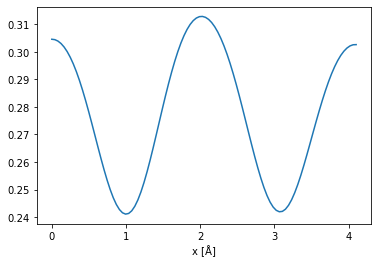

In [160]:
#ax=Measurement.read('linescan.hdf5').show()
measurements[haadf].show()
#print(ax)